In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from statsmodels.stats.proportion import proportions_ztest
from unsupervised_bias_detection.cluster import BiasAwareHierarchicalKMeans

#### A. Load data and data preparation

##### A.1 Load data

In [2]:
# Load the COMPAS dataset
file_path = "./FP-test-set.csv"
df = pd.read_csv(file_path, delimiter=';')

# Display the first few rows of the dataset
df.head()

,length,#URLs,#mentions,#hashs,verified,#followers,user_engagement,sentiment_score,FP
0,84,2,0,1,1,1828600,102.622934,-0.4767,0
1,93,1,0,0,1,45988032,82.510668,0.0000,0
2,89,1,0,0,1,16023476,155.112226,0.0000,0
3,80,1,0,0,1,3629813,601.280035,-0.6486,0
4,87,0,0,0,0,3479057,253.795131,0.0000,0


##### A.2 Data cleaning

In [3]:
# Check for missing values
print(df.isnull().sum())

length             0
#URLs              0
#mentions          0
#hashs             0
verified           0
#followers         0
user_engagement    0
sentiment_score    0
FP                 0
dtype: int64


**UI text #1** (only demo)

**Information about demo dataset**

...


**UI text #2**

In this example, we analyze which group is most adversely affected by the risk prediction algorithm. We do this by applying the clustering algorithm on the dataset previewed below. A preview of the data can be found below. The column `false_positive` is used as the `bias score`.

**0. Preview of data**

[below table with top-5 rows]

In [4]:
filtered_df = df
filtered_df.head()

,length,#URLs,#mentions,#hashs,verified,#followers,user_engagement,sentiment_score,FP
0,84,2,0,1,1,1828600,102.622934,-0.4767,0
1,93,1,0,0,1,45988032,82.510668,0.0000,0
2,89,1,0,0,1,16023476,155.112226,0.0000,0
3,80,1,0,0,1,3629813,601.280035,-0.6486,0
4,87,0,0,0,0,3479057,253.795131,0.0000,0


In [5]:
# Convert all columns except 'FP' to float64, and 'FP' to int
filtered_df = filtered_df.astype({col: 'float64' for col in filtered_df.columns if col != 'FP'})
filtered_df['FP'] = filtered_df['FP'].astype(int)
filtered_df.dtypes

length             float64
#URLs              float64
#mentions          float64
#hashs             float64
verified           float64
#followers         float64
user_engagement    float64
sentiment_score    float64
FP                   int64
dtype: object

In [6]:
# Create a dataframe from filtered_df except the bias metric column
bias_score = "FP"
df_no_bias_score = filtered_df.drop(columns=[bias_score])
if df_no_bias_score.dtypes.nunique() == 1:
    print('consistent data')
else:
    print('not all columns in the provided dataset have the same data type')

consistent data


##### A.3 Explanatory data analysis

In [7]:
# for this notebook only
dim = filtered_df.shape
print(dim)
n = dim[0]

(413, 9)


In [8]:
filtered_df[bias_score].value_counts()

FP
0    394
1     19
Name: count, dtype: int64

**UI text #3**

**1. Paramters selected for clustering**

- Number of iterations: {n_iter}
- Minimal cluster size: {n_iter}
- Bias score: {bias_score}

#### B. Split dataset in train and test set

Only multiply by -1 if "Lower value of bias metric is better" box in web app is ticked, becuase HBAC implementation in the package assumes that higher `y` is better.

In [9]:
# split the data into training and testing sets
train_df, test_df = train_test_split(filtered_df, test_size=0.2, random_state=42)
X_train = train_df.drop(columns=[bias_score])

# bias metric is negated because HBAC implementation in the package assumes that higher bias metric is better
y_train = train_df[bias_score] * -1

# remove the bias metric from the test set to prevent issues with decoding later
X_test = test_df.drop(columns=[bias_score])

# display the shapes of the resulting datasets
print(f"Training set shape: {train_df.shape}")
print(f"Testing set shape: {test_df.shape}")

Training set shape: (330, 9)
Testing set shape: (83, 9)


**UI text #4**

**2. Splitting dataset**

To reduce the possibility that the clustering method detects noise, the dataset is split in a train (80%) and test dataset (20%). The clustering method is first fitted on the train dataset. Then, the presence of statistically significant bias in deviating clusters is evaluated using the test dataset.

- Training set shape: {train_df.shape[0]}
- Testing set shape: {test_df.shape[0]}

#### C. Fitting HBAC - kmodes

In [10]:
# n_iter (here: 10 times) and min_cluster (10 training dataset) can be specified by the user in the web app
hbac = BiasAwareHierarchicalKMeans(bahc_max_iter=10, bahc_min_cluster_size=10)
hbac.fit(X_train, y_train)

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but BiasAwareHierarchicalClustering was fitted without feature names
  warnings.warn(


BiasAwareHierarchicalKMeans(bahc_max_iter=10, bahc_min_cluster_size=10)

In [11]:
# number of clusters
hbac.n_clusters_

2

In [12]:
# bias metric scores
hbac.scores_

array([ 0.04100946, -0.04100946])

In [13]:
# number of datapoints is cluster, user can specify cluster label (here cluster_label=0)
cluster_label = 0 # specified by user
n_cluster = np.sum(hbac.labels_ == cluster_label)
print(f"Number of datapoints in cluster {cluster_label}: {n_cluster}/{train_df.shape[0]}")

Number of datapoints in cluster 0: 317/330


**UI text #5**

**3. Clustering results**

- Number of clusters detected: {hbac.n_clusters_}
- Number of datapoints in cluster with most bias: {n_most_bias}/{train_df.shape[0]}

In [14]:
# assign cluster label to the test set, based on results from the training set
y_test = hbac.predict(X_test.to_numpy())
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=uint32)

#### D. Assigning cluster labels to test set

In [15]:
test_df["cluster_label"] = y_test
test_df.head()

,length,#URLs,#mentions,#hashs,verified,#followers,user_engagement,sentiment_score,FP,cluster_label
394,94.0,1.0,1.0,1.0,1.0,1004803.0,32.646837,0.3724,0,0
349,54.0,1.0,0.0,0.0,0.0,205.0,0.012082,-0.9246,0,0
400,119.0,1.0,0.0,0.0,0.0,8568.0,19.950813,-0.4404,0,0
353,103.0,1.0,1.0,0.0,1.0,20738.0,41.745414,-0.8979,0,0
181,119.0,1.0,0.0,0.0,1.0,15880382.0,62.613488,0.0000,0,0


#### E. Testing differences in bias metric

- $H_0$: no difference in bias between the most deviating cluster and the rest of the dataset
- $H_1$: difference in bias between the most deviating cluster and the rest of the dataset

A two-sided t-test is performed to accept or reject $H_0$.

In [16]:
# Filter test_df to only include rows with the most biased cluster label
most_biased_cluster_df = test_df[test_df["cluster_label"] == 0]
rest_df = test_df[test_df["cluster_label"] != 0]

In [17]:
# Convert score_text to numeric
bias_score_most_biased = pd.to_numeric(most_biased_cluster_df[bias_score])
bias_score_rest = pd.to_numeric(rest_df[bias_score])

# Perform independent two-sample t-test (two-sided: average bias metric in most_biased_cluster_df ≠ average bias metric in rest_df)
t_stat, p_val = ttest_ind(bias_score_most_biased, bias_score_rest, alternative='two-sided')

print(f"T-statistic: {t_stat}")
print(f"p-value: {p_val}")

if p_val < 0.05:
    print("The most biased cluster has a significantly higher average bias metric than the rest of the dataset.")
else:
    print("No significant difference in average bias metric between the most biased cluster and the rest of the dataset.")

T-statistic: 0.6376727264232777
p-value: 0.5254852599559459
No significant difference in average bias metric between the most biased cluster and the rest of the dataset.


**UI text #7**

[if p<0.05] The most biased cluster has a significantly higher average bias metric compared to the rest of the dataset. Use the figures below to examine the characteristics of this cluster. [4. Visualization should be shown]

[if p≥0.05] There is no significant difference in the average bias metric between the most biased cluster and the rest of the dataset. There is no evidence that certain groups are more frequently associated with the bias metric than others. [4. Visualization shouldn't be shown]

**4. Visualization**

[if p<0.05]

**UI text #8**

Below the characteristics most biased cluster (label 0) are shown. 

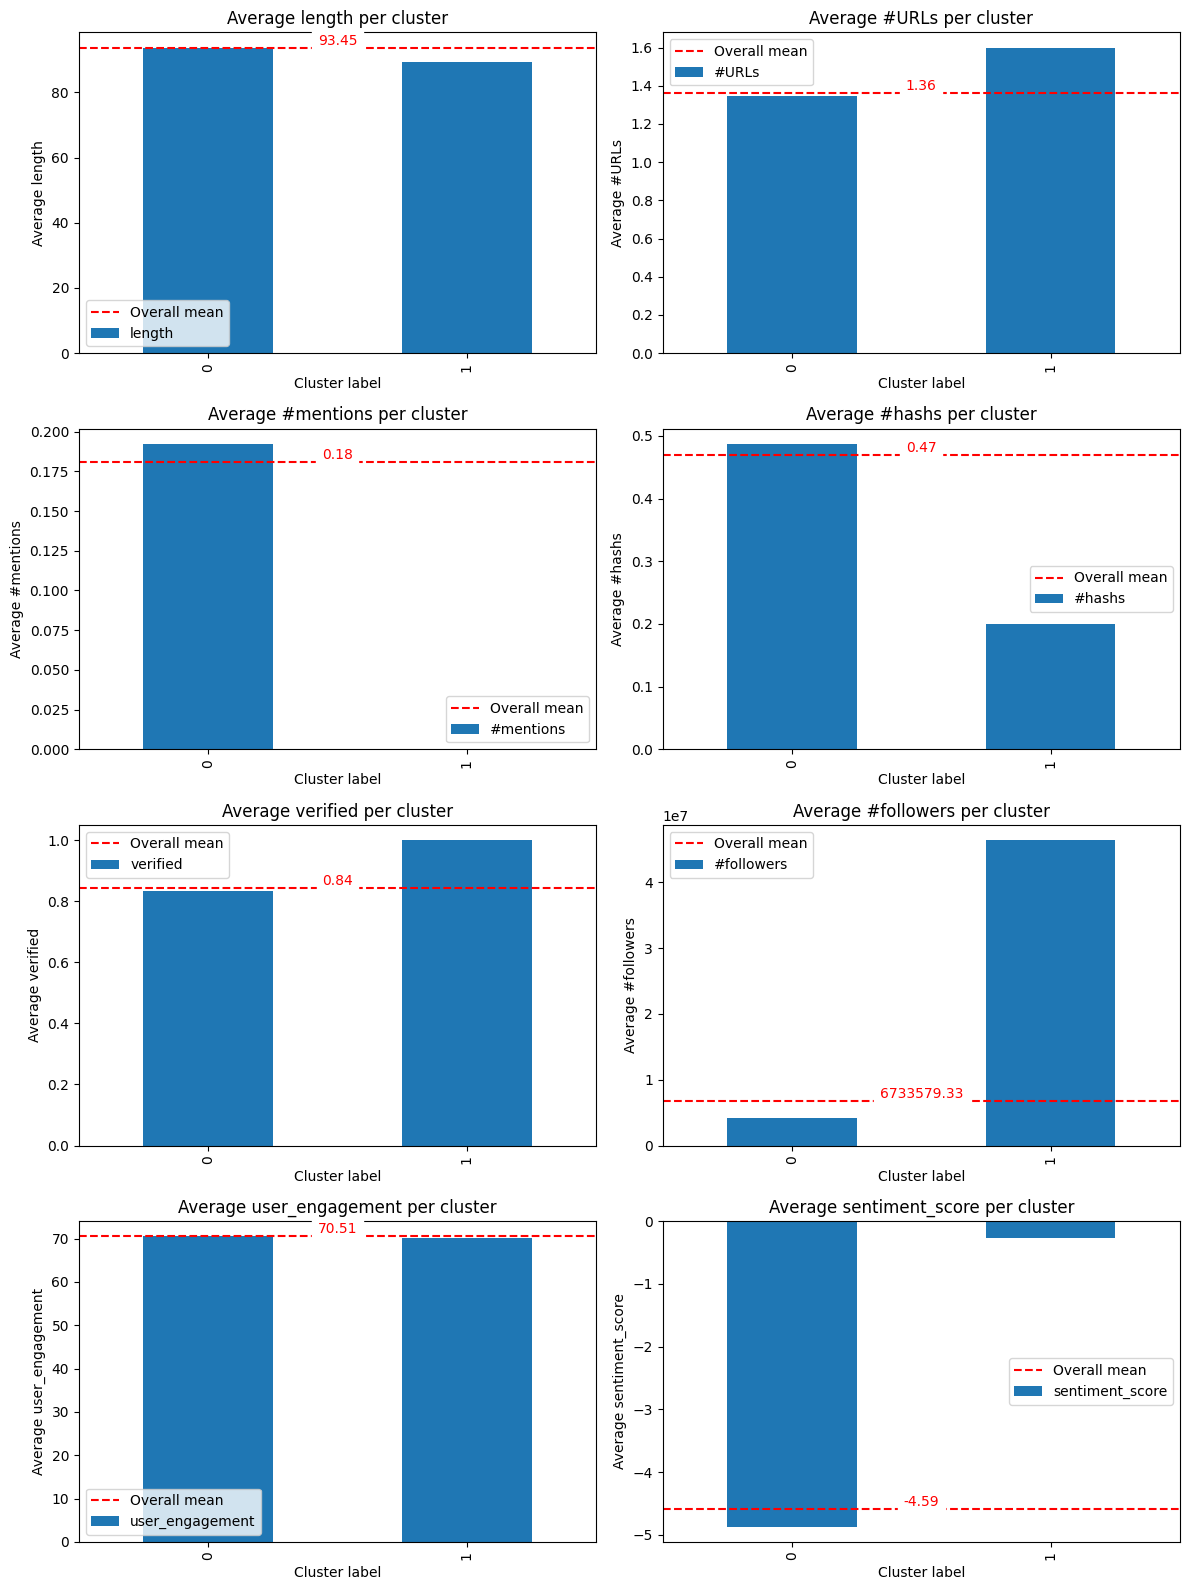

In [18]:
# Calculate mean per cluster for each variable
means = test_df.groupby("cluster_label").mean()

# Calculate overall mean for each variable (excluding cluster_label)
variables = X_test.columns.tolist()
overall_means = test_df[variables].mean()

# Plot bar charts for each variable, showing means for each cluster and overall mean as red line
n_vars = len(variables)
n_cols = 2
n_rows = int(np.ceil(n_vars / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, var in enumerate(variables):
    means[var].plot(kind="bar", ax=axes[i])
    axes[i].axhline(overall_means[var], color='red', linestyle='--', label='Overall mean')
    axes[i].set_title(f"Average {var} per cluster")
    axes[i].set_xlabel("Cluster label")
    axes[i].set_ylabel(f"Average {var}")
    # Annotate the overall mean value
    y = overall_means[var]
    x = 0.5  # center between clusters for annotation
    axes[i].annotate(f"{y:.2f}", xy=(x, y), xytext=(x, y), color='red', fontsize=10,
                     ha='center', va='bottom', backgroundcolor='white')
    axes[i].legend()

# Hide any unused subplots
for i in range(n_vars, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

#### F. Testing statistical significance for features of most deviating cluster vs rest of dataset

In [19]:
def t_test_on_cluster(test_df, bias_score, cluster_label):

    # Prepare results dictionary
    t_test_results = {}

    cluster_df = test_df[test_df["cluster_label"] == cluster_label]
    rest_df = test_df[test_df["cluster_label"] != cluster_label]

    for var in test_df.drop(columns=[bias_score, "cluster_label"]).columns:
        # values in both partitions
        values_cluster = cluster_df[var]
        values_rest = rest_df[var]

        # means per partition
        mean_cluster = cluster_df[var].mean()
        mean_rest = rest_df[var].mean()
        diff = mean_cluster - mean_rest

        # Perform two-sided t-test
        t_stat, p_val = ttest_ind(values_cluster, values_rest, equal_var=False)
        t_test_results[var] = {''
            't_stat': t_stat, 
            'p_val': p_val,
            "direction": "higher" if diff > 0 else "lower"
        }

    # print if any statistically significant differences in means for most deviating cluster and the rest of the dataset was found or not
    if any(res['p_val'] < 0.05 for res in t_test_results.values()):
        print(f"\033[92mStatistically significant differences in means found:\033[0m")
    else:
        print(f"\033[91mNo statistically significant differences in means found.\033[0m")

    # if significant differences were found, print the variables with their differences
    for var, res in t_test_results.items():
        if res['p_val'] < 0.05:
            direction = res['direction']
            if direction == "higher":
                print(f"\033[92m{var}: occur in the most deviating cluster more often than in the rest of the dataset.\033[0m")
            else:
                print(f"\033[92m{var}: occur in the most deviating cluster less often than in the rest of the dataset.\033[0m")
        else:
            continue

In [20]:
# statistical testing results for most deviating cluster (label=0)
t_test_on_cluster(test_df, bias_score, cluster_label=0)

Statistically significant differences in means found:
#mentions: occur in the most deviating cluster more often than in the rest of the dataset.
verified: occur in the most deviating cluster less often than in the rest of the dataset.
#followers: occur in the most deviating cluster less often than in the rest of the dataset.


/var/folders/v8/64zc34sn3b95klfm660085h80000gn/T/ipykernel_92900/1219081472.py:20: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = ttest_ind(values_cluster, values_rest, equal_var=False)


In [21]:
# [not in web app]
n_cluster = hbac.n_clusters_
for i in range(0,n_cluster):
    print("Cluster: ", i)
    t_test_on_cluster(test_df, bias_score, cluster_label=i)

Cluster:  0
Statistically significant differences in means found:
#mentions: occur in the most deviating cluster more often than in the rest of the dataset.
verified: occur in the most deviating cluster less often than in the rest of the dataset.
#followers: occur in the most deviating cluster less often than in the rest of the dataset.
Cluster:  1
Statistically significant differences in means found:
#mentions: occur in the most deviating cluster less often than in the rest of the dataset.
verified: occur in the most deviating cluster more often than in the rest of the dataset.
#followers: occur in the most deviating cluster more often than in the rest of the dataset.


/var/folders/v8/64zc34sn3b95klfm660085h80000gn/T/ipykernel_92900/1219081472.py:20: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = ttest_ind(values_cluster, values_rest, equal_var=False)
/var/folders/v8/64zc34sn3b95klfm660085h80000gn/T/ipykernel_92900/1219081472.py:20: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = ttest_ind(values_cluster, values_rest, equal_var=False)


#### G. Conclusion

**UI text #9**

**6. Conclusion**

From the above figures and statistical tests, it can be concluded that: 

[output of cell 21 can be ignored for now]

[if p<0.05]

The most biased cluster has a statistically significant higher average bias score than the rest of the dataset.

[if p>0.05]

No statistically significant difference in average bias score between the most biased cluster and the rest of the dataset.

**7. More information**
- [Scientific article](https://arxiv.org/pdf/2502.01713)
- [Github repository](https://github.com/NGO-Algorithm-Audit/unsupervised-bias-detection)